In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [78]:
image = cv2.imread('./datasets/coco/images/train2017/000000009801.jpg')
input_point = np.array([[418, 549],[57, 480]])
input_label = np.array([1]*2)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(640, 633, 3)

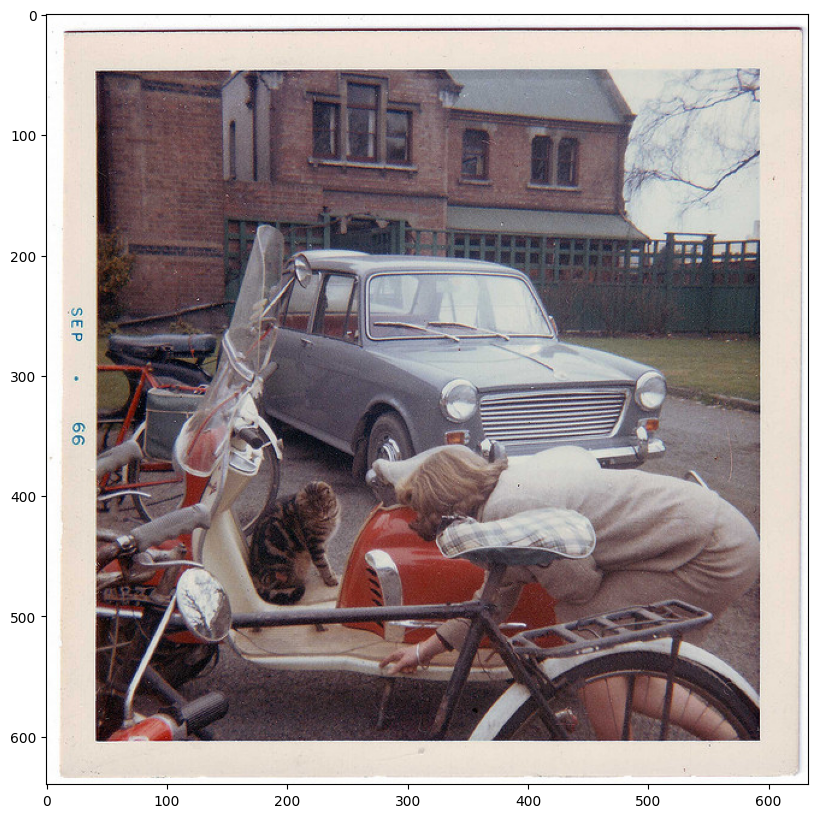

In [75]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [76]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = r"E:\mqj\myjob\path\sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
del sam

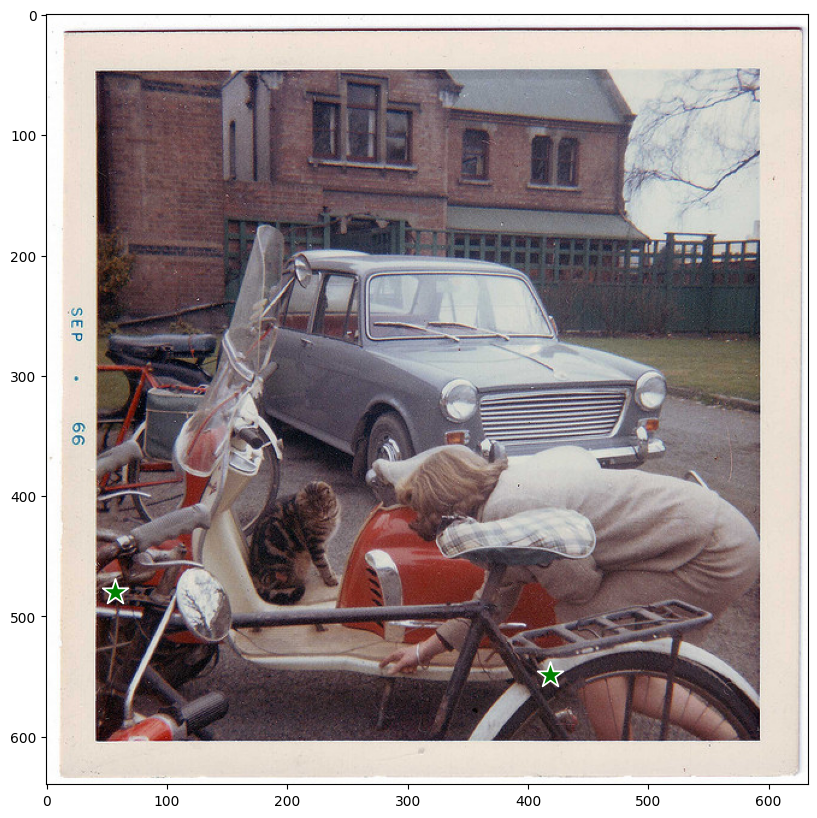

(3, 640, 633)


In [79]:
predictor.set_image(image)
input_point = input_point
input_label = input_label
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
#plt.savefig(r'E:\mqj\myjob\Mask-free-OVIS-main\datasets\pick\giraffes.jpg')
plt.show()  
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
print(masks.shape)

In [68]:
input_boxes = torch.tensor([
    [172, 400, 238, 480]
], device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
true_masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
masks.shape 

(3, 640, 633)

In [69]:
def calculate_miou(gt_mask, pred_mask):
    # Calculate True Positives, False Positives, and False Negatives for each class
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    tp = np.sum(intersection)
    fp = np.sum(pred_mask) - tp
    fn = np.sum(gt_mask) - tp
    # Calculate Mean Intersection over Union
    miou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    return miou

def calculate_mpa(gt_mask, pred_mask):
    # Calculate True Positives for each class
    tp = np.sum(np.logical_and(gt_mask == 1, pred_mask == 1))
    # Calculate False Positives for each class
    fp = np.sum(np.logical_and(gt_mask == 0, pred_mask == 1))
    # Calculate Mean Pixel Accuracy
    mpa = tp / (tp + fp) if (tp + fp) > 0 else 0
    return mpa

In [70]:
iou = 0
pa = 0
num_seg = 0
for mask in masks:
    num_seg +=1
    for tr_mask in true_masks:
        print(1 in tr_mask.cpu().numpy())
        print(calculate_miou(tr_mask.cpu().numpy(), mask))
        print(calculate_mpa(tr_mask.cpu().numpy(), mask))
        iou += calculate_miou(tr_mask.cpu().numpy(), mask)
        pa += calculate_mpa(tr_mask.cpu().numpy(), mask)
print(round(iou/num_seg,3))
print(pa/num_seg)

True
0.0
0.0
True
0.0
0.0
True
0.0
0.0
0.0
0.0


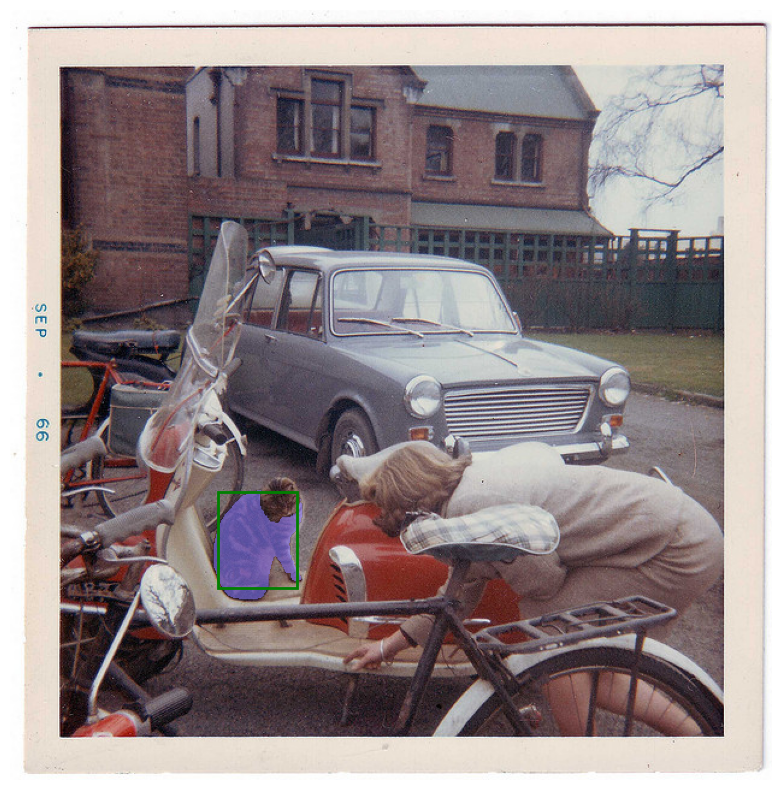

In [71]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in true_masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.savefig(f'./datasets/pick/womanx.jpg')
plt.show()

True
True


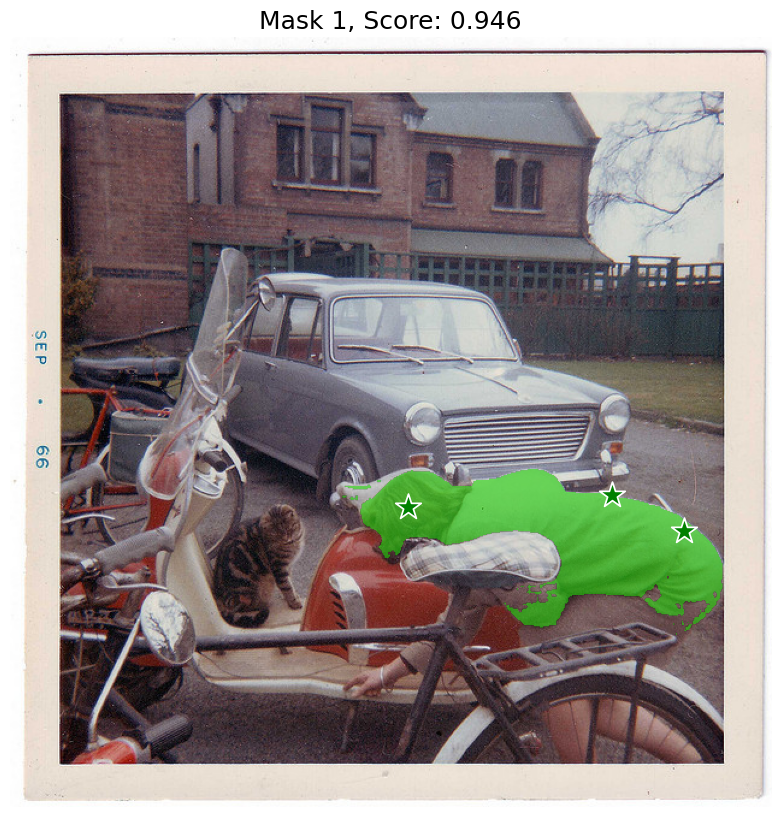

True
True


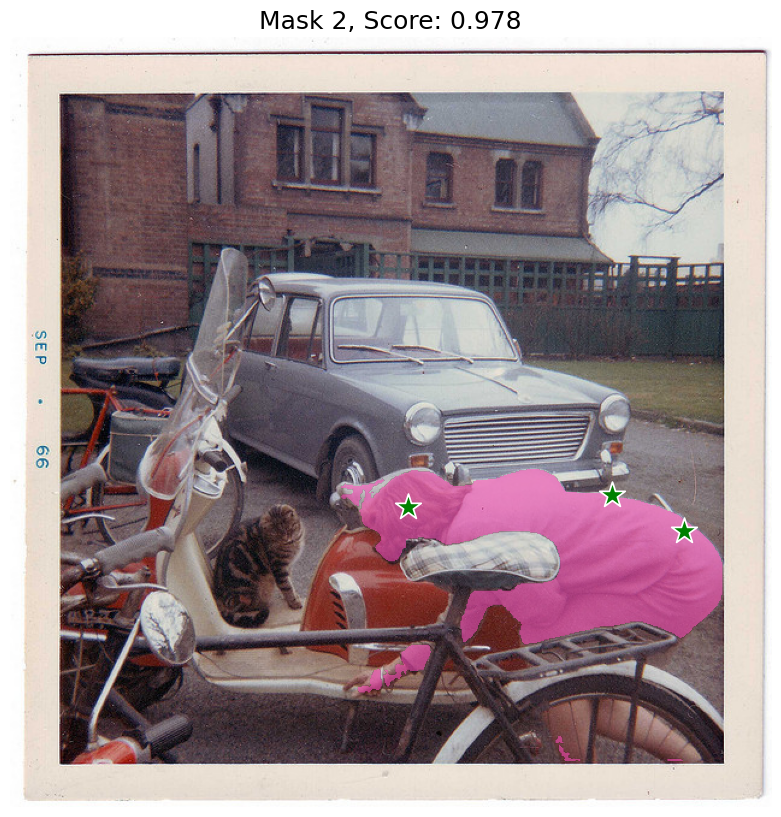

True
True


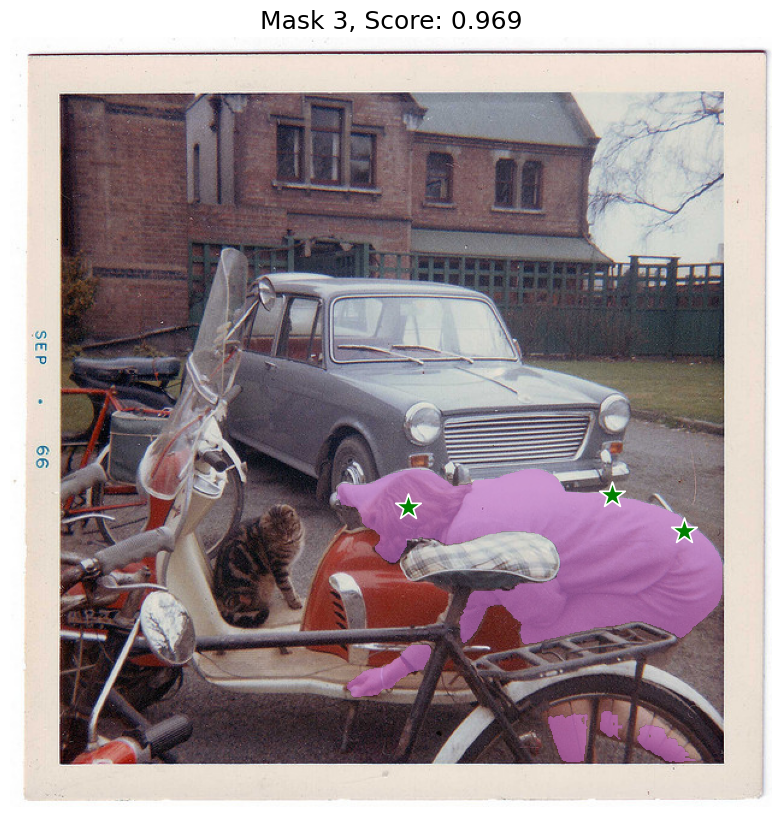

In [72]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    print(1 in mask)
    print(0 in mask)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.savefig(f'./datasets/pick/woman+{i}.jpg')
    plt.show()
    

In [73]:
torch.cuda.empty_cache()